In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
(train_images,train_labels),(test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

In [3]:
train_images.shape

(50000, 32, 32, 3)

In [4]:
train_data = train_images.reshape([-1, 32, 32, 3]).astype(np.float32) / 255
test_data = test_images.reshape([-1, 32, 32, 3]).astype(np.float32) / 255

####Convolutional Autoencoder

In [5]:
class Autoencoder:

  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.input_layer = tf.keras.Input((32, 32, 3))
    self.code_shape = 64
  
  def UNET(self):
    en_conv_layer_1 = tf.keras.layers.Conv2D((self.code_shape)*1,(3, 3), padding='same', activation='relu')(self.input_layer)
    en_conv_layer_1 = tf.keras.layers.Conv2D((self.code_shape)*1,(3, 3), padding='same', activation='relu')(en_conv_layer_1)
    pool_layer_1 = tf.keras.layers.MaxPool2D()(en_conv_layer_1)
    pool_layer_1 = tf.keras.layers.Dropout(0.25)(pool_layer_1)

    en_conv_layer_2 = tf.keras.layers.Conv2D((self.code_shape)*2,(3, 3), padding='same', activation='relu')(pool_layer_1)
    en_conv_layer_2 = tf.keras.layers.Conv2D((self.code_shape)*2,(3, 3), padding='same', activation='relu')(en_conv_layer_2)
    pool_layer_2 = tf.keras.layers.MaxPool2D()(en_conv_layer_2)
    pool_layer_2 = tf.keras.layers.Dropout(0.25)(pool_layer_2)

    en_conv_layer_3 = tf.keras.layers.Conv2D((self.code_shape)*4,(3, 3), padding='same', activation='relu')(pool_layer_2)
    en_conv_layer_3 = tf.keras.layers.Conv2D((self.code_shape)*4,(3, 3), padding='same', activation='relu')(en_conv_layer_3)
    pool_layer_3 = tf.keras.layers.MaxPool2D()(en_conv_layer_3)
    pool_layer_3 = tf.keras.layers.Dropout(0.25)(pool_layer_3)

    en_conv_layer_4 = tf.keras.layers.Conv2D((self.code_shape)*8,(3, 3), padding='same', activation='relu')(pool_layer_3)
    en_conv_layer_4 = tf.keras.layers.Conv2D((self.code_shape)*8,(3, 3), padding='same', activation='relu')(en_conv_layer_4)
    pool_layer_4 = tf.keras.layers.MaxPool2D()(en_conv_layer_4)
    pool_layer_4 = tf.keras.layers.Dropout(0.25)(pool_layer_4)


    en_conv_bottleneck_layer = tf.keras.layers.Conv2D((self.code_shape)*16,(3, 3), padding='same', activation='relu')(pool_layer_4)
    en_conv_bottleneck_layer = tf.keras.layers.Conv2D((self.code_shape)*16,(3, 3), padding='same', activation='relu')(en_conv_bottleneck_layer)

  
    de_conv_layer_4 = tf.keras.layers.Conv2DTranspose((self.code_shape)*8,(3,3), strides=(2,2), padding='same')(en_conv_bottleneck_layer)
    con_conv_layer_4 = tf.keras.layers.concatenate([de_conv_layer_4, en_conv_layer_4])
    con_conv_layer_4 = tf.keras.layers.Dropout(0.25)(con_conv_layer_4)
    con_conv_layer_4 = tf.keras.layers.Conv2D((self.code_shape)*8, (3,3), activation='relu', padding='same')(con_conv_layer_4)
    con_conv_layer_4 = tf.keras.layers.Conv2D((self.code_shape)*8, (3,3), activation='relu', padding='same')(con_conv_layer_4)
    
    
    de_conv_layer_3 = tf.keras.layers.Conv2DTranspose((self.code_shape)*8,(3,3), strides=(2,2), padding='same')(con_conv_layer_4)
    con_conv_layer_3 = tf.keras.layers.concatenate([de_conv_layer_3, en_conv_layer_3])
    con_conv_layer_3 = tf.keras.layers.Dropout(0.25)(con_conv_layer_3)
    con_conv_layer_3 = tf.keras.layers.Conv2D((self.code_shape)*4, (3,3), activation='relu', padding='same')(con_conv_layer_3)
    con_conv_layer_3 = tf.keras.layers.Conv2D((self.code_shape)*4, (3,3), activation='relu', padding='same')(con_conv_layer_3)
    
    de_conv_layer_2 = tf.keras.layers.Conv2DTranspose((self.code_shape)*8,(3,3), strides=(2,2), padding='same')(con_conv_layer_3)
    con_conv_layer_2 = tf.keras.layers.concatenate([de_conv_layer_2, en_conv_layer_2])
    con_conv_layer_2 = tf.keras.layers.Dropout(0.25)(con_conv_layer_2)
    con_conv_layer_2 = tf.keras.layers.Conv2D((self.code_shape)*2, (3,3), activation='relu', padding='same')(con_conv_layer_2)
    con_conv_layer_2 = tf.keras.layers.Conv2D((self.code_shape)*2, (3,3), activation='relu', padding='same')(con_conv_layer_2)
    
    de_conv_layer_1 = tf.keras.layers.Conv2DTranspose((self.code_shape)*8,(3,3), strides=(2,2), padding='same')(con_conv_layer_2)
    con_conv_layer_1 = tf.keras.layers.concatenate([de_conv_layer_1, en_conv_layer_1])
    con_conv_layer_1 = tf.keras.layers.Dropout(0.25)(con_conv_layer_1)
    con_conv_layer_1 = tf.keras.layers.Conv2D((self.code_shape)*3, (3,3), activation='relu', padding='same')(con_conv_layer_1)
    con_conv_layer_1 = tf.keras.layers.Conv2D((self.code_shape)*3, (3,3), activation='relu', padding='same')(con_conv_layer_1)
    
    output_layer = tf.keras.layers.Conv2D(3, (1,1), padding='same', activation='sigmoid')(con_conv_layer_1)

    return en_conv_bottleneck_layer, self.input_layer, output_layer

In [6]:
def model_compile_fit_evaluate(input_layer, output_layer, train_data, test_data):
 
  #---model compile-----
  model = tf.keras.Model(input_layer, output_layer)
  model.compile(optimizer='adam', loss='MSE')
  
  model.summary()
  
  #---model fit------
  model.fit(train_data, train_data,
            epochs=3,
            batch_size=64,
            shuffle=True,
            validation_data=(test_data, test_data))

In [7]:
autoencoder = Autoencoder()
encoder, input_layer, output_layer = autoencoder.UNET()

####SSL

In [8]:
model_compile_fit_evaluate(input_layer, output_layer, train_data, test_data)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

####Custom Layer

In [12]:
def build_custom_layer(input, encoder_layers):
  encoder = tf.keras.Model(input, encoder_layers)
  encoder.trainable = False
  #encoder.trainable = True
  print(encoder.trainable_variables)
  pool_layer = tf.keras.layers.MaxPool2D()(encoder_layers)
  flatten = tf.keras.layers.Flatten()(pool_layer)
  dense_layer_1 = tf.keras.layers.Dense(64, activation=tf.nn.leaky_relu)(flatten)
  dense_layer_2 = tf.keras.layers.Dense(10, activation=tf.nn.softmax)(dense_layer_1)
  
  output = dense_layer_2

  custom_model = tf.keras.Model(inputs=input, outputs=output)

  return custom_model

#### With encoder trainable parameters

In [51]:
custom_model_encoder_train_true = build_custom_layer(input_layer, encoder)
custom_model_encoder_train_true.summary()
custom_model_encoder_train_true.compile(
      loss = tf.losses.SparseCategoricalCrossentropy(from_logits=False),
      optimizer = tf.optimizers.Adam(),
      metrics = tf.keras.metrics.SparseCategoricalAccuracy()
      )
train_scores = custom_model_encoder_train_true.fit(train_data, train_labels, epochs=10)
test_scores = custom_model_encoder_train_true.evaluate(test_data, test_labels)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

[<tf.Variable 'conv2d_132/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
array([[[[-0.08834569,  0.0308381 , -0.05906138, ..., -0.03612944,
           0.076372  , -0.09463416],
         [ 0.0956842 ,  0.01026718,  0.09025383, ..., -0.05760114,
          -0.09475926, -0.07531941],
         [-0.09690194,  0.07423486,  0.09640408, ...,  0.01356134,
          -0.01666481,  0.03305434]],

        [[ 0.04491395, -0.03785003, -0.0446834 , ..., -0.08800891,
           0.03304401, -0.02354665],
         [-0.08555092, -0.07941873, -0.09809518, ..., -0.0274822 ,
           0.09605409,  0.07978845],
         [ 0.05466999, -0.00806551,  0.07237703, ...,  0.07803197,
           0.05481349, -0.06061185]],

        [[ 0.0732705 , -0.05180865, -0.08804522, ...,  0.05779651,
           0.0993381 ,  0.00358412],
         [ 0.04496767,  0.00932813,  0.00461254, ..., -0.03534652,
          -0.04576736,  0.09128694],
         [-0.04994163, -0.0189465 , -0.08432743, ..., -0.041179  ,
          -0.046083

####Without encoder trainable variables

In [9]:
custom_model_encoder_train_false = build_custom_layer(input_layer, encoder)
custom_model_encoder_train_false.summary()
custom_model_encoder_train_false.compile(
      loss = tf.losses.SparseCategoricalCrossentropy(from_logits=False),
      optimizer = tf.optimizers.Adam(),
      metrics = tf.keras.metrics.SparseCategoricalAccuracy()
      )
train_scores_new = custom_model_encoder_train_false.fit(train_data, train_labels, epochs=10)
test_scores_new = custom_model_encoder_train_false.evaluate(test_data, test_labels)
print("Test loss:", test_scores_new[0])
print("Test accuracy:", test_scores_new[1])

[]
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                        

####Denoise Autoencoder

In [9]:
from skimage.util import random_noise

noise_factor = 0.07

train_data_noisy = random_noise(train_data, mode="s&p",clip=True, amount=noise_factor)
test_data_noisy = random_noise(test_data, mode="s&p",clip=True, amount=noise_factor)

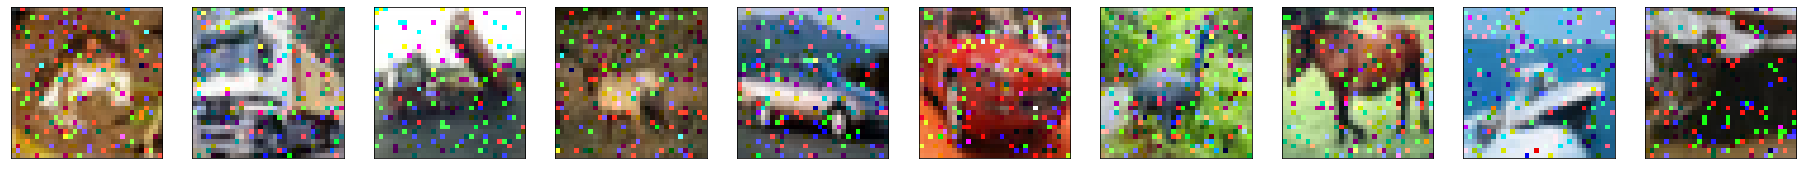

In [10]:
plt.figure(figsize=(32, 32))
n=10
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(train_data_noisy[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [11]:
model = tf.keras.Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='MSE')
  
model.summary()
  
#---model fit------
model.fit(train_data_noisy, train_data,
          epochs=3,
          batch_size=64,
          shuffle=True,
          validation_data=(test_data_noisy, test_data))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 64)   0           ['conv2d_1[0][0]']               
                                                                                            